# Phase Picking (PhaseNet)

Next, I will use `PhaseNet` and `Pyrocko` to pick P and S phases and their polarity.
Lastly, I will use `HASH(fortran)` and `SKHASH (python)` to determine the focal mechanisms.

---

### Import all necessary libraries here, this will make things easier later

In [1]:
import os
import glob
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime, read_inventory, Inventory, read, Stream

# Setup all directories

In [2]:
# set up the project directory
project_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_dir = os.path.join(project_dir, "data/eq_data")
catalog_dir = os.path.join(data_dir, "1_eq_catalogs")
waveform_dir = os.path.join(data_dir, "2_waveforms")
station_dir = os.path.join(data_dir, "3_station_catalogs")

pn_dt_dir = os.path.join(project_dir, "results/phasenet_diting_others")
pn_dir = os.path.join(pn_dt_dir, "phasenet_files")
os.makedirs(pn_dir, exist_ok=True)

phasenet_git_path = os.path.abspath(os.path.join(os.getcwd(), "../../../../Software_docs/PhaseNet"))

# 1. Use `Phasenet` to pick P and S phases
An example of phasenet terminal code is: \
`python phasenet/predict.py --model=model/190703-214543 --data_list=test_data/mseed.csv --data_dir=test_data/mseed --format=mseed --result_dir./phasenet_results --result_fname=phasenet_phasepick_datetime.csv`

___ \

[[for more details]](https://github.com/AI4EPS/PhaseNet/blob/master/docs/example_batch_prediction.ipynb)

### Make a folder to store the results
- Also make a list of .mseed files (only filename for phasenet) and put it in a .csv file

In [5]:
# Make a list of .mseed files into a csv file to input into PhaseNet command line
mseed_list = [os.path.basename(fname) for fname in glob.glob(f"{waveform_dir}/*.mseed")]

# Write the list to a csv file
pd.DataFrame(mseed_list, columns=["fname"]).to_csv(f"{pn_dir}/mseed_list.csv", index=False, header=True)
print(f"Number of mseed files : {len(mseed_list)}")

Number of mseed files : 921


## Process mseeds
- resample = 100 Hz

### Make a bash script for running Phasenet

In [18]:
from classes_functions.other_fun import make_phasenet_script
script_content = make_phasenet_script(
    phasenet_git_path,
    waveform_dir=f"{waveform_dir}",
    data_list=f"{pn_dir}/mseed_list.csv",
    result_dir=pn_dir,
    result_fname='phasenet_phasepick_3d_grid_921',
    conda_env='miniconda3',
    )
# print(script_content)

# Write the script content to a file
with open(f"{pn_dir}/run_phasenet.sh", "w") as f:
    f.write(script_content)

# Make the script executable
print("Making the script executable...")
os.system(f"chmod +x {pn_dir}/run_phasenet.sh")

Making the script executable...


0

### Run Phasenet script:
If it's already run, it will ask if you want to run again.

In [19]:
# Run the script
run = input("Do you want to run PhaseNet now? (y/n): ")
if run.lower() == "y":
    print("Running PhaseNet...")
    os.system(f"{pn_dir}/run_phasenet.sh")
else:
    print("PhaseNet already run. Skipping...")

Running PhaseNet...


2024-05-13 12:17:03,219 Pred log: /Users/mdarifulislam/Library/CloudStorage/OneDrive-IndianaUniversity/Research/Github/FM2STRESS/FM2STRESS_project/results/phasenet_diting_others/phasenet_files
2024-05-13 12:17:03,219 Dataset size: 921
2024-05-13 12:17:03,281 Model: depths 5, filters 8, filter size 7x1, pool size: 4x1, dilation rate: 1x1
2024-05-13 12:17:04.025806: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2024-05-13 12:17:04.078744: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-05-13 12:17:04,217 restoring model model/190703-214543/model_95.ckpt
Pred: 100%|██████████| 921/921 [05:20<00:00,  2.87it/s]


Done with 39868 P-picks and 11 S-picks


## Plot fresh picks

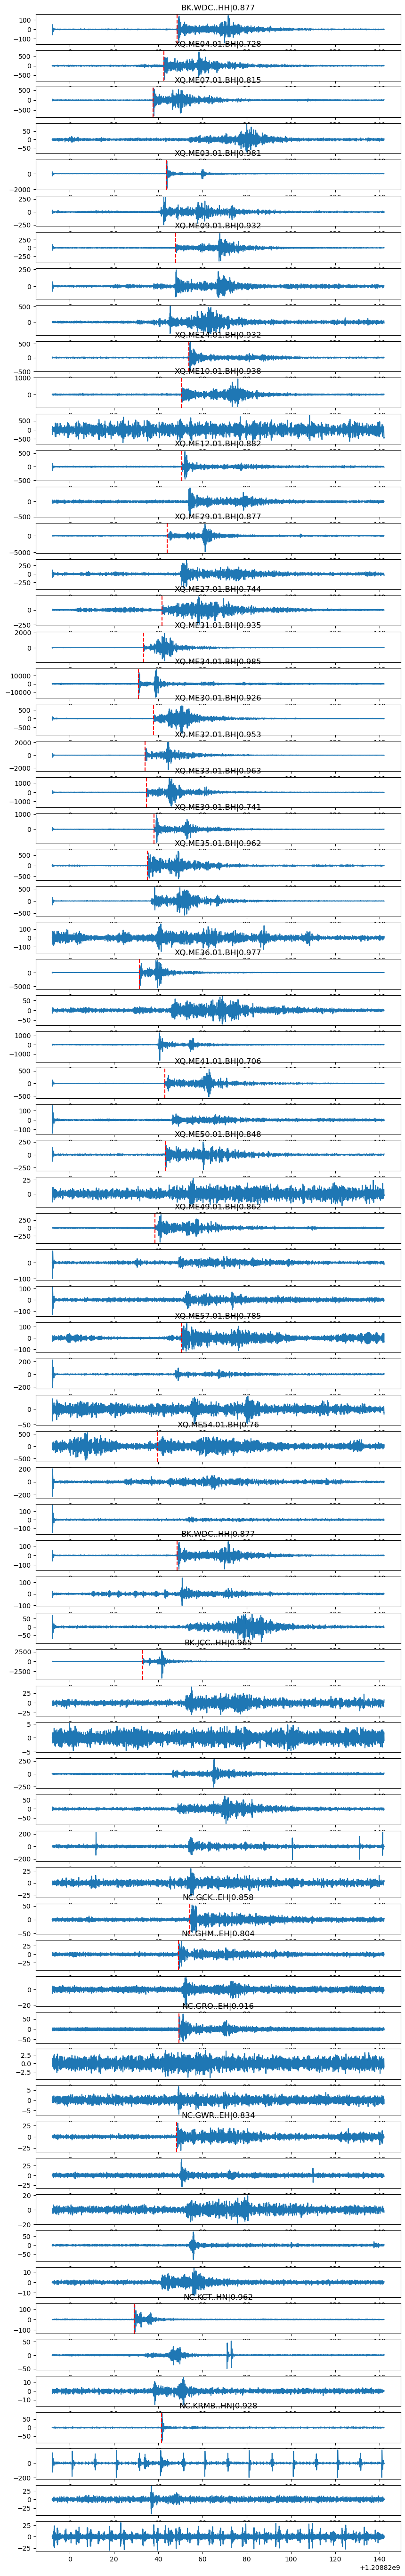

In [21]:
# Read the pick dataframe 
pn_pick_df = pd.read_csv(f'{pn_dir}/phasenet_phasepick_3d_grid_921.csv', parse_dates=['begin_time', 'phase_time'])
event_df = pn_pick_df[pn_pick_df["file_name"] == f"{selected_file}"]

st = read(f"{processed_mseed_dir}/{selected_file}")

fig, axs = plt.subplots(len(st), 1, figsize=(10, len(st)))

for i, tr in enumerate(st):
    station_id = tr.id[:-1]
    row = event_df[event_df["station_id"] == station_id]
    timex = np.arange(tr.stats.starttime, tr.stats.endtime+tr.stats.delta, tr.stats.delta)
    axs[i].plot(timex, tr.data, label=station_id)
    if len(row) > 0:
        pn_time = UTCDateTime(pd.to_datetime(row.phase_time.values[0]))
        axs[i].axvline(pn_time, color='r', linestyle='--', label='P pick')
        axs[i].set_title(f"{station_id}|{row.phase_score.values[0]}")


## Process the PhaseNet output:
### If the pick is earlier than the `event_time` (from USGS catalog) remove that row.
Also add a event-to-station distance column to the data,
And sort by distance. 
Then check if phase_time increases or not with increasing distance. 
Define a threshold lag time, if time increament is much bigger than the threshold time, remove this row.


### Add event-to-distance column and sort by it

In [22]:
# path to inventory file, catalog file and pick file
inv_file = f'{project_dir}/data/eq_data/3_station_catalogs/' + '00_station_inventory_921.txt'
eq_cat_file = f'{catalog_dir}/usgs_catalog_2008-01-01_2024-01-01_M2.csv'
pn_pick_file = f'{pn_dir}/phasenet_phasepick_3d_grid_921.csv'

# Read the pick dataframe and the catalog dataframe
pn_pick_df = pd.read_csv(pn_pick_file, parse_dates=['begin_time', 'phase_time'])
eq_cat_df = pd.read_csv(eq_cat_file, parse_dates=['time'])

# Add distance column to the pick dataframe
from classes_functions.other_fun import add_sta_dist_to_polpick
%reload_ext autoreload
%autoreload 2

pn_pick_w_dist_df = add_sta_dist_to_polpick(eq_cat_file, pn_pick_file, inv_file)

# sort the dataframe by file_name and sta_dist_km
pn_pick_w_dist_df.sort_values(by=['file_name', 'sta_dist_km'], inplace=True)
pn_pick_w_dist_df = pn_pick_w_dist_df.reset_index(drop=True)

# # keep high confidence picks
conf = 85
pn_pick_w_dist_df = pn_pick_w_dist_df[pn_pick_w_dist_df['phase_score'] >= conf/100]

pn_pick_w_dist_df.to_csv(f"{pn_dir}/PN_w_stdist_921.csv", index=False)
pn_pick_w_dist_df.head()

Station WR.ORV 
Station UW.LAB 
Station UW.LAB 
Station WR.ORV 
Station UW.LAB 
Station WR.ORV 
Station UW.LAB 
Station UO.KBO 
Station WR.ORV 
Station UW.LAB 
Station WR.ORV 
Station WR.ORV 
Station WR.ORV 
Station WR.ORV 
Station WR.ORV 
Station WR.ORV 
Station WR.ORV 
Station WR.ORV 
Station WR.ORV 
Station WR.ORV 
Station WR.ORV 
Station WR.ORV 
Station WR.ORV 
Station WR.ORV 
Station WR.ORV 
Station WR.ORV 
Station WR.ORV 
Station WR.ORV 
Station WR.ORV 
Station WR.ORV 
Station WR.ORV 
Station WR.ORV 
Station WR.ORV 
Station WR.ORV 
Station NC.LGO 
Station UO.KBO 
Station UO.KBO 
Station NC.LGO 
Station UO.KBO 
Station NC.LGO 
Station NC.LGO 
Station NC.LGO 
Station NC.LGO 
Station NC.LGO 
Station NC.LGO 
Station NC.LGO 
Station NC.LGO 
Station UO.KBO 
Station UO.KBO 
Station NC.LGO 
Station UO.KBO 
Station UO.KBO 
Station UO.KBO 


,station_id,begin_time,phase_index,phase_time,phase_score,phase_type,file_name,phase_amplitude,phase_amp,sta_dist_km
0,XQ.ME31.01.BH,2008-04-04T17:10:56.150,3415,2008-04-04T17:11:30.300,0.955,P,nc40214567.mseed,14003.805664,14003.805664,5.65
1,XQ.ME32.01.BH,2008-04-04T17:10:56.150,3462,2008-04-04T17:11:30.770,0.969,P,nc40214567.mseed,10884.021484,10884.021484,10.78
2,BK.JCC..HH,2008-04-04T17:10:56.150,3486,2008-04-04T17:11:31.010,0.975,P,nc40214567.mseed,4026.403564,4026.403564,18.23
3,XQ.ME33.01.BH,2008-04-04T17:10:56.150,3599,2008-04-04T17:11:32.140,0.932,P,nc40214567.mseed,5679.313965,5679.313965,23.61
4,XQ.ME35.01.BH,2008-04-04T17:10:56.150,3731,2008-04-04T17:11:33.460,0.949,P,nc40214567.mseed,5652.571289,5652.571289,25.94


### Now, we remove picks that arrive earlier than the event time (wrong pick)
### And unusual velocity (>7/8)

In [23]:
# read the distance sorted data 
# pn_pick_w_dist_df = pd.read_csv(f"{pn_dir}/PN_{conf}c_w_stdist.csv", parse_dates=['begin_time', 'phase_time'])

# copy the dataframe to edit
pn_pick_varified_df = pn_pick_w_dist_df.copy()
pn_pick_varified_df.phase_time = pd.to_datetime(pn_pick_varified_df.phase_time)

orig_len = pn_pick_w_dist_df.shape[0]

# group by file_name
df_groupes = pn_pick_varified_df.groupby('file_name')

ct, cv = 0, 0

for file_name, group in df_groupes:
    event_id = file_name.split('.')[0]
    event_time = eq_cat_df.loc[eq_cat_df.id == event_id, 'time'].values[0]
    event_time = pd.to_datetime(event_time) 
    # print(f"Event ID: {event_id}, Event Time: {event_time}")

    for i, row in group.iterrows():
        # check if PickTime is earlier than EventTime
        dt = (row.phase_time - event_time).total_seconds()
        vel = row.sta_dist_km / dt
        
        # remove picks if pick time is earlier than event time
        if dt < 0:
            # print(row.station_id, 'dt: ', dt)
            pn_pick_varified_df.drop(i, inplace=True)
            ct += 1

        # remove picks if velocity is greater than 8 km/s
        if vel > 8:
            # print(row.station_id, 'vel: ', vel)
            pn_pick_varified_df.drop(i, inplace=True)
            cv += 1
       
new_len = pn_pick_varified_df.shape[0]
print(f"Removed {orig_len - new_len} picks.")
print(f"Removed {ct} picks due to negative time difference.")
print(f"Removed {cv} picks due to high velocity.")

# save the dataframe
pn_pick_varified_df.to_csv(f"{pn_dir}/PN_w_stdist_varified_921.csv", index=False)  

Removed 1411 picks.
Removed 1213 picks due to negative time difference.
Removed 198 picks due to high velocity.


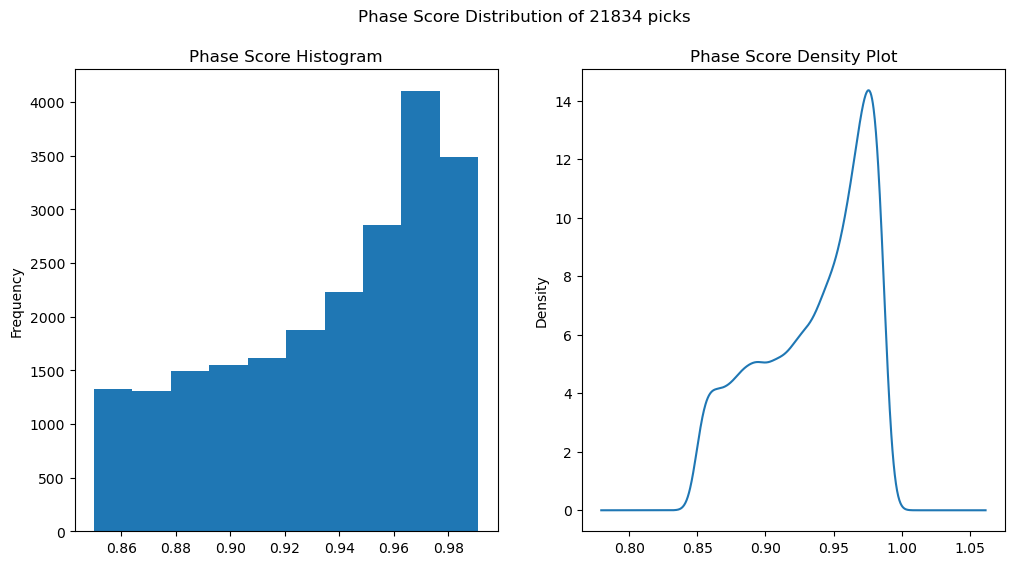

In [24]:
# plot phase_score distribution as histogram and density plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
pn_pick_varified_df["phase_score"].plot(kind="hist", bins=10, ax=ax[0], title="Phase Score Histogram")
pn_pick_varified_df["phase_score"].plot(kind="kde", ax=ax[1], title="Phase Score Density Plot")

plt.suptitle(f"Phase Score Distribution of {pn_pick_varified_df.shape[0]} picks")
plt.show()